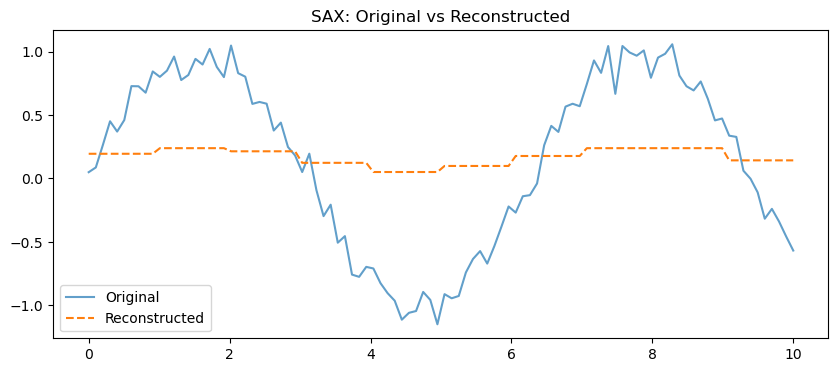

In [30]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Generate synthetic time series
np.random.seed(42)
t = np.linspace(0, 10, 100)
ts = np.sin(t) + np.random.normal(0, 0.1, 100)  # Univariate
ts_multi = np.vstack([np.sin(t), np.cos(t)]).T + np.random.normal(0, 0.1, (100, 2))  # Multivariate


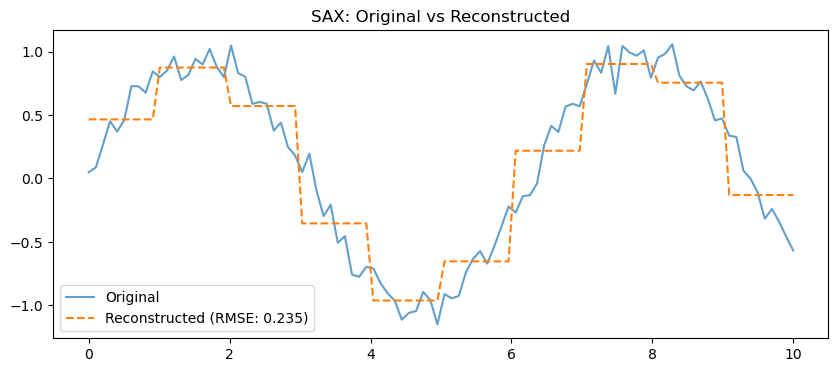

In [38]:
class SAX:
    def __init__(self, window_size, alphabet_size):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_symbols = None
    
    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        n_samples = len(X)
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        paa_values = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            segment = X_norm[idx:idx + size]
            mean_val = np.mean(segment)
            paa_values.append(mean_val)
            symbol = np.digitize([mean_val], self.breakpoints)[0]
            symbols.append(chr(97 + symbol))
            idx += size
        self.last_paa_values = np.array(paa_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        if symbols is None:
            symbols = self.last_symbols
            paa_values = self.last_paa_values
        else:
            symbols = np.array([ord(s) - 97 for s in symbols])
            # Map symbols back to approximate PAA values using breakpoints
            breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
            paa_values = np.array([norm.expect(lambda x: x, loc=0, scale=1, 
                                              lb=breakpoints_ext[i], ub=breakpoints_ext[i+1])
                                  for i in symbols])
        recon_norm = []
        for val, size in zip(paa_values, self.segment_sizes):
            recon_norm.extend([val] * size)
        return np.array(recon_norm) * self.std + self.mean

# Test and visualize
sax = SAX(window_size=10, alphabet_size=8)
symbols = sax.fit_transform(ts)
recon = sax.inverse_transform()
rmse = np.sqrt(np.mean((ts - recon) ** 2))
plt.figure(figsize=(10, 4))
plt.plot(t, ts, label="Original", alpha=0.7)
plt.plot(t, recon, label=f"Reconstructed (RMSE: {rmse:.3f})", linestyle="--")
plt.title("SAX: Original vs Reconstructed")
plt.legend()
plt.show()

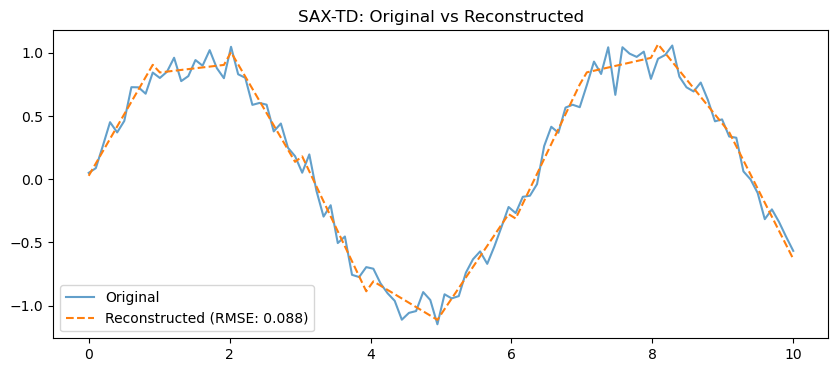

In [39]:
class SAXTD:
    def __init__(self, window_size, alphabet_size, slope_threshold=0.01):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.slope_threshold = slope_threshold
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_slopes = None
        self.last_symbols = None
    
    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        n_samples = len(X)
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        paa_values = []
        slopes = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            start = idx
            end = idx + size
            segment = X_norm[start:end]
            mean_val = np.mean(segment)
            slope, _ = np.polyfit(np.arange(len(segment)), segment, 1)
            paa_values.append(mean_val)
            slopes.append(slope)
            mean_symbol = np.digitize([mean_val], self.breakpoints)[0]
            trend = 'u' if slope > self.slope_threshold else ('d' if slope < -self.slope_threshold else 'f')
            symbols.append(f"{chr(97 + mean_symbol)}{trend}")
            idx += size
        self.last_paa_values = np.array(paa_values)
        self.last_slopes = np.array(slopes)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        if symbols is None:
            paa_values = self.last_paa_values
            slopes = self.last_slopes
        else:
            paa_values = []
            slopes = []
            for s in symbols:
                mean_symbol = ord(s[0]) - 97
                trend = s[1]
                breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                mean_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                       lb=breakpoints_ext[mean_symbol], 
                                       ub=breakpoints_ext[mean_symbol + 1])
                slope = (self.slope_threshold if trend == 'u' else 
                         (-self.slope_threshold if trend == 'd' else 0))
                paa_values.append(mean_val)
                slopes.append(slope)
            paa_values = np.array(paa_values)
            slopes = np.array(slopes)
        recon_norm = []
        for val, slope, size in zip(paa_values, slopes, self.segment_sizes):
            segment = val + slope * np.linspace(-size/2, size/2, size)
            recon_norm.extend(segment)
        return np.array(recon_norm) * self.std + self.mean

# Test and visualize
saxtd = SAXTD(window_size=10, alphabet_size=8)
symbols = saxtd.fit_transform(ts)
recon = saxtd.inverse_transform()
rmse = np.sqrt(np.mean((ts - recon) ** 2))
plt.figure(figsize=(10, 4))
plt.plot(t, ts, label="Original", alpha=0.7)
plt.plot(t, recon, label=f"Reconstructed (RMSE: {rmse:.3f})", linestyle="--")
plt.title("SAX-TD: Original vs Reconstructed")
plt.legend()
plt.show()

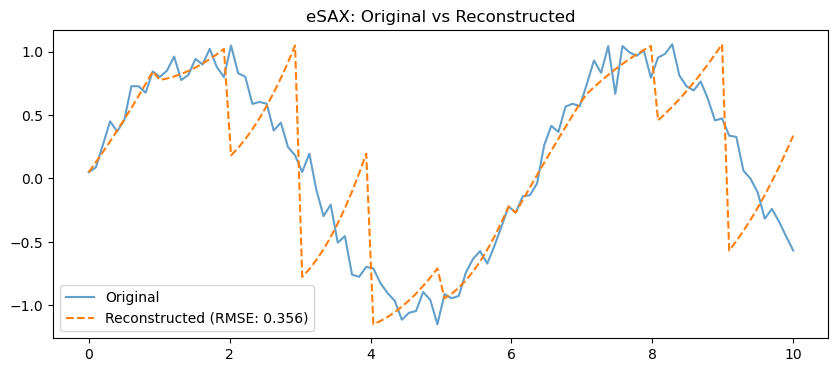

In [41]:
from scipy.interpolate import interp1d

class ESAX:
    def __init__(self, window_size, alphabet_size):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_sizes = None
        self.last_min_values = None
        self.last_mean_values = None
        self.last_max_values = None
        self.last_symbols = None
    
    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        n_samples = len(X)
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        min_values = []
        mean_values = []
        max_values = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            start = idx
            end = idx + size
            segment = X_norm[start:end]
            min_val = np.min(segment)
            mean_val = np.mean(segment)
            max_val = np.max(segment)
            min_values.append(min_val)
            mean_values.append(mean_val)
            max_values.append(max_val)
            min_symbol = np.digitize([min_val], self.breakpoints)[0]
            mean_symbol = np.digitize([mean_val], self.breakpoints)[0]
            max_symbol = np.digitize([max_val], self.breakpoints)[0]
            symbols.append(f"{chr(97 + min_symbol)}{chr(97 + mean_symbol)}{chr(97 + max_symbol)}")
            idx += size
        self.last_min_values = np.array(min_values)
        self.last_mean_values = np.array(mean_values)
        self.last_max_values = np.array(max_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        if symbols is None:
            min_values = self.last_min_values
            mean_values = self.last_mean_values
            max_values = self.last_max_values
        else:
            min_values = []
            mean_values = []
            max_values = []
            for s in symbols:
                breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                min_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                      lb=breakpoints_ext[ord(s[0]) - 97], 
                                      ub=breakpoints_ext[ord(s[0]) - 96])
                mean_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                       lb=breakpoints_ext[ord(s[1]) - 97], 
                                       ub=breakpoints_ext[ord(s[1]) - 96])
                max_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                      lb=breakpoints_ext[ord(s[2]) - 97], 
                                      ub=breakpoints_ext[ord(s[2]) - 96])
                min_values.append(min_val)
                mean_values.append(mean_val)
                max_values.append(max_val)
            min_values = np.array(min_values)
            mean_values = np.array(mean_values)
            max_values = np.array(max_values)
        recon_norm = []
        for min_val, mean_val, max_val, size in zip(min_values, mean_values, max_values, self.segment_sizes):
            x = [0, size/2, size-1]
            y = [min_val, mean_val, max_val]
            f = interp1d(x, y, kind='quadratic', fill_value="extrapolate")
            segment = f(np.arange(size))
            recon_norm.extend(segment)
        return np.array(recon_norm) * self.std + self.mean

# Test and visualize
esax = ESAX(window_size=10, alphabet_size=8)
symbols = esax.fit_transform(ts)
recon = esax.inverse_transform()
rmse = np.sqrt(np.mean((ts - recon) ** 2))
plt.figure(figsize=(10, 4))
plt.plot(t, ts, label="Original", alpha=0.7)
plt.plot(t, recon, label=f"Reconstructed (RMSE: {rmse:.3f})", linestyle="--")
plt.title("eSAX: Original vs Reconstructed")
plt.legend()
plt.show()

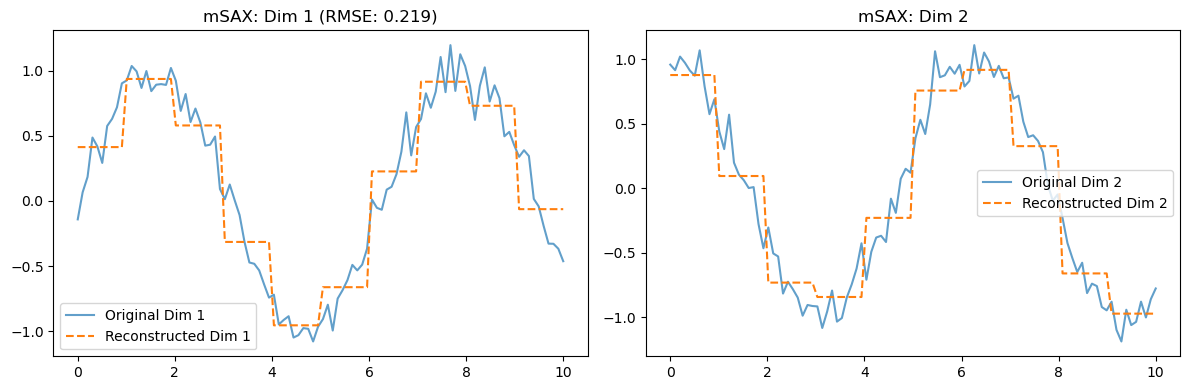

In [46]:
class MSAX:
    def __init__(self, window_size, alphabet_size):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.breakpoints = None
        self.means = None
        self.stds = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_symbols = None
    
    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.means = np.mean(X, axis=0)
        self.stds = np.std(X, axis=0)
        self.stds[self.stds < 1e-10] = 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.means) / self.stds
        n_samples, n_dims = X.shape
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        paa_values = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            start = idx
            end = idx + size
            segment = X_norm[start:end, :]
            mean_vals = np.mean(segment, axis=0)
            paa_values.append(mean_vals)
            dim_symbols = [np.digitize([val], self.breakpoints)[0] for val in mean_vals]
            symbols.append("".join(chr(97 + s) for s in dim_symbols))
            idx += size
        self.last_paa_values = np.array(paa_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        if symbols is None:
            paa_values = self.last_paa_values
        else:
            paa_values = []
            for s in symbols:
                vals = []
                for c in s:
                    idx = ord(c) - 97
                    breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                    val = norm.expect(lambda x: x, loc=0, scale=1, 
                                      lb=breakpoints_ext[idx], ub=breakpoints_ext[idx + 1])
                    vals.append(val)
                paa_values.append(vals)
            paa_values = np.array(paa_values)
        n_dims = paa_values.shape[1]
        recon_norm = np.zeros((sum(self.segment_sizes), n_dims))
        idx = 0
        for vals, size in zip(paa_values, self.segment_sizes):
            recon_norm[idx:idx + size, :] = vals
            idx += size
        recon = recon_norm * self.stds + self.means
        return recon[:len(recon_norm)]

# Test and visualize
msax = MSAX(window_size=10, alphabet_size=8)
symbols = msax.fit_transform(ts_multi)
recon = msax.inverse_transform()
rmse = np.sqrt(np.mean((ts_multi - recon) ** 2))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, ts_multi[:, 0], label="Original Dim 1", alpha=0.7)
plt.plot(t, recon[:, 0], label=f"Reconstructed Dim 1", linestyle="--")
plt.legend()
plt.title(f"mSAX: Dim 1 (RMSE: {rmse:.3f})")
plt.subplot(1, 2, 2)
plt.plot(t, ts_multi[:, 1], label="Original Dim 2", alpha=0.7)
plt.plot(t, recon[:, 1], label=f"Reconstructed Dim 2", linestyle="--")
plt.legend()
plt.title("mSAX: Dim 2")
plt.tight_layout()
plt.show()

aSAX segment_sizes: [ 6 27  7  5 14  7  5 14  9  6], Sum: 100
aSAX segment_bounds: [  0   6  33  40  45  59  66  71  85  94 100]
aSAX reconstructed length: 100
Original length: 100, Reconstructed length: 100


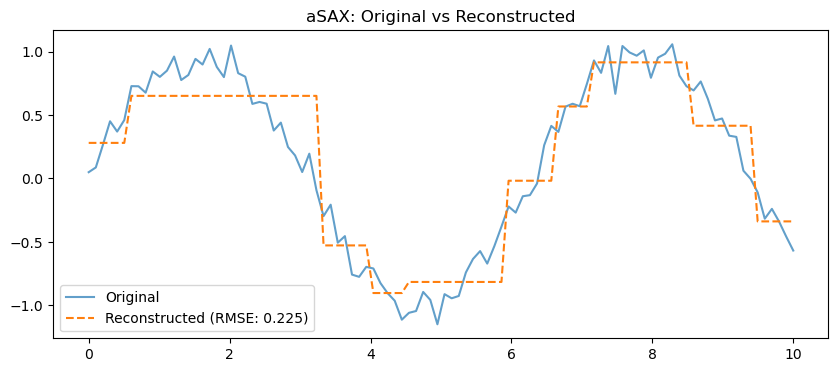

In [50]:
class ASAX:
    def __init__(self, n_segments, alphabet_size, min_segment_size=5):
        self.n_segments = n_segments
        self.alphabet_size = alphabet_size
        self.min_segment_size = min_segment_size
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_bounds = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_symbols = None
    
    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        n_samples = len(X)
        X_norm = (X - self.mean) / self.std
        
        # Compute adaptive segment sizes
        window = max(n_samples // self.n_segments, self.min_segment_size)
        stds = [np.std(X_norm[i:i + window]) if i + window <= n_samples else np.std(X_norm[i:]) 
                for i in range(0, n_samples, window)]
        stds = np.array(stds)
        if len(stds) < self.n_segments:
            stds = np.pad(stds, (0, self.n_segments - len(stds)), mode='edge')
        elif len(stds) > self.n_segments:
            stds = stds[:self.n_segments]
        inv_stds = 1 / (stds + 1e-10)
        total_weight = inv_stds.sum()
        
        # Distribute n_samples across n_segments
        segment_sizes = np.floor(inv_stds / total_weight * n_samples).astype(int)
        segment_sizes = np.clip(segment_sizes, self.min_segment_size, None)
        # Adjust to ensure sum equals n_samples
        current_sum = segment_sizes.sum()
        if current_sum != n_samples:
            diff = n_samples - current_sum
            for i in range(abs(diff)):
                idx = np.argmax(segment_sizes) if diff > 0 else np.argmin(segment_sizes)
                segment_sizes[idx] += 1 if diff > 0 else -1
                segment_sizes[idx] = max(self.min_segment_size, segment_sizes[idx])
        self.segment_sizes = segment_sizes
        self.segment_bounds = np.cumsum([0] + segment_sizes.tolist())
        
        # Validate
        print(f"aSAX segment_sizes: {self.segment_sizes}, Sum: {self.segment_sizes.sum()}")
        print(f"aSAX segment_bounds: {self.segment_bounds}")
        if self.segment_bounds[-1] != n_samples or len(self.segment_sizes) != self.n_segments:
            raise ValueError(f"Invalid segment bounds: {self.segment_bounds[-1]} vs {n_samples}, "
                             f"or wrong number of segments: {len(self.segment_sizes)} vs {self.n_segments}")
        
        return self
    
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        paa_values = []
        symbols = []
        for i in range(self.n_segments):
            start = self.segment_bounds[i]
            end = self.segment_bounds[i + 1]
            if start >= end or end > len(X_norm):
                raise ValueError(f"Invalid segment [{start}:{end}] for length {len(X_norm)}")
            segment = X_norm[start:end]
            mean_val = np.mean(segment)
            if np.isnan(mean_val):
                mean_val = 0  # Handle empty or invalid segments
            paa_values.append(mean_val)
            symbol = np.digitize([mean_val], self.breakpoints)[0]
            symbols.append(chr(97 + symbol))
        self.last_paa_values = np.array(paa_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        if symbols is None:
            paa_values = self.last_paa_values
        else:
            paa_values = []
            for s in symbols:
                idx = ord(s) - 97
                breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                val = norm.expect(lambda x: x, loc=0, scale=1, 
                                  lb=breakpoints_ext[idx], ub=breakpoints_ext[idx + 1])
                paa_values.append(val)
            paa_values = np.array(paa_values)
        recon_norm = []
        for i, val in enumerate(paa_values):
            segment_size = self.segment_bounds[i + 1] - self.segment_bounds[i]
            recon_norm.extend([val] * segment_size)
        recon = np.array(recon_norm) * self.std + self.mean
        print(f"aSAX reconstructed length: {len(recon)}")
        return recon
# Test and visualize (ASAX only)
asax = ASAX(n_segments=10, alphabet_size=8)
symbols = asax.fit_transform(ts)
recon = asax.inverse_transform()
print(f"Original length: {len(ts)}, Reconstructed length: {len(recon)}")
rmse = np.sqrt(np.mean((ts - recon) ** 2))
plt.figure(figsize=(10, 4))
plt.plot(t, ts, label="Original", alpha=0.7)
plt.plot(t, recon, label=f"Reconstructed (RMSE: {rmse:.3f})", linestyle="--")
plt.title("aSAX: Original vs Reconstructed")
plt.legend()
plt.show()



Testing standard time series (length=100)
SAX reconstructed length: 100
0.2353862649856282


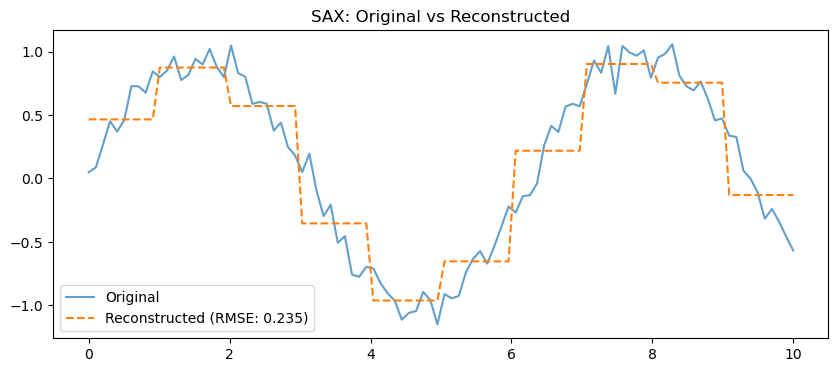

SAX-TD reconstructed length: 100
0.08755080560648505


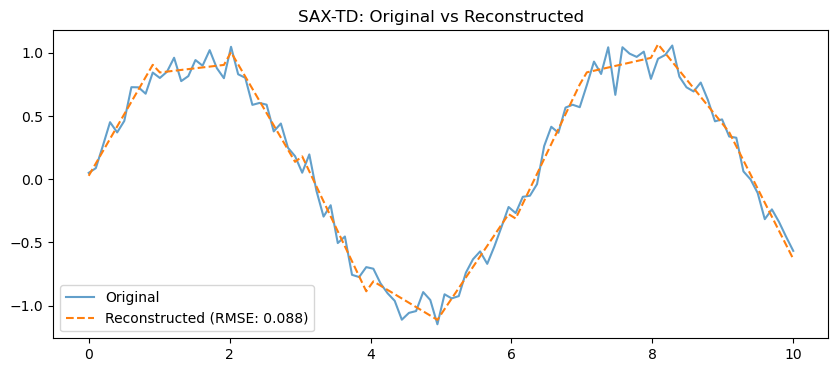

eSAX reconstructed length: 100
0.35562841562115677


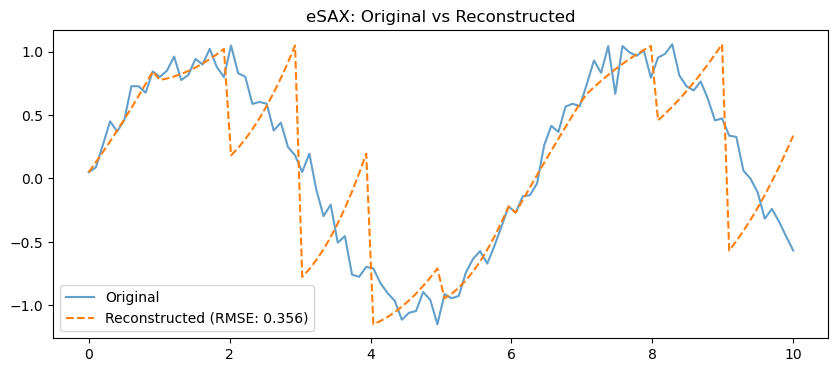

mSAX reconstructed length: 100
0.21873322830378136


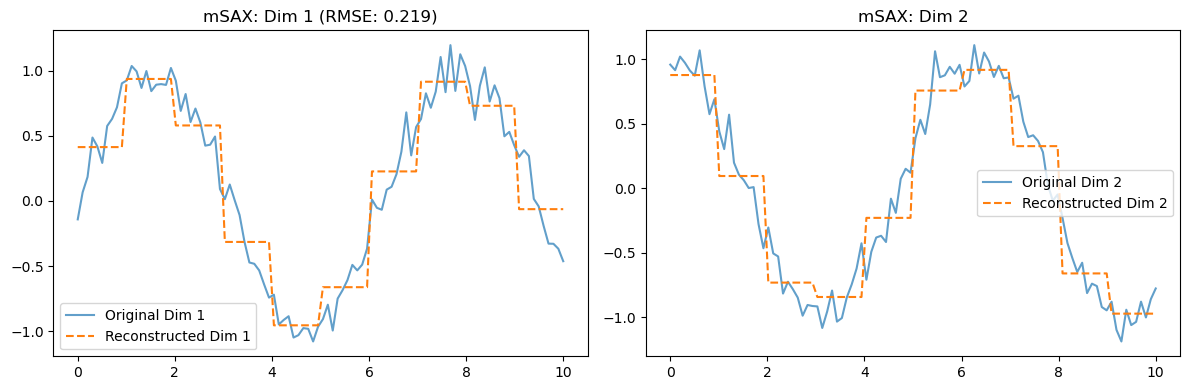

aSAX segment_sizes: [ 7 23  7  6 14  8  6 14  9  6], Sum: 100
aSAX segment_bounds: [  0   7  30  37  43  57  65  71  85  94 100]
aSAX reconstructed length: 100
0.19375838808452822


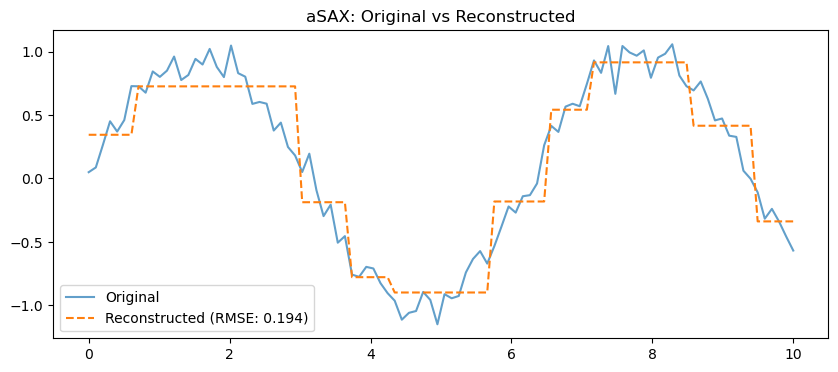


Testing constant time series (length=100)
SAX reconstructed length: 100
0.0


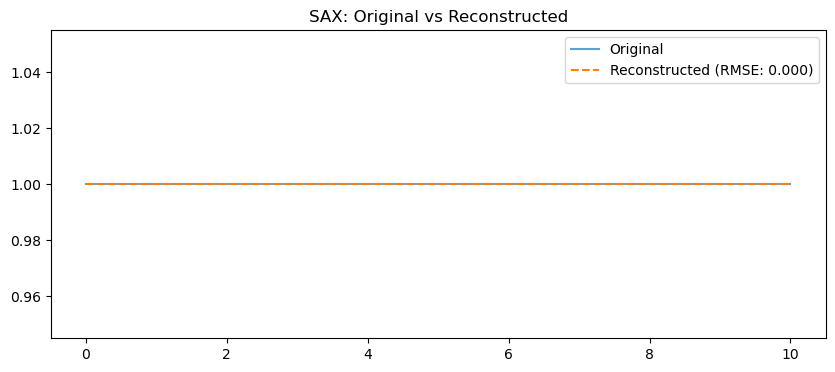

SAX-TD reconstructed length: 100
0.0


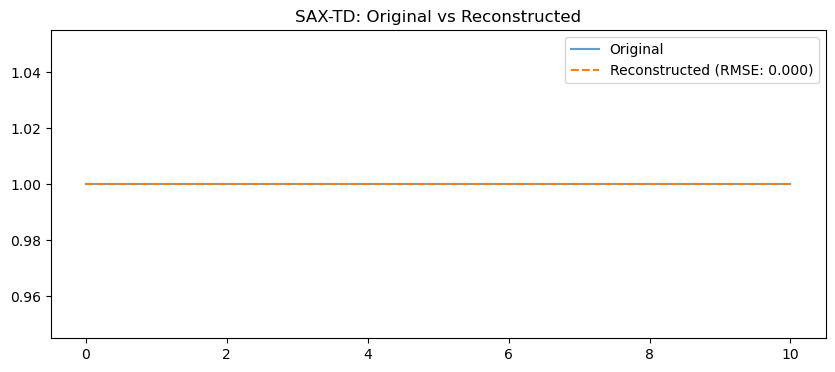

eSAX reconstructed length: 100
0.0


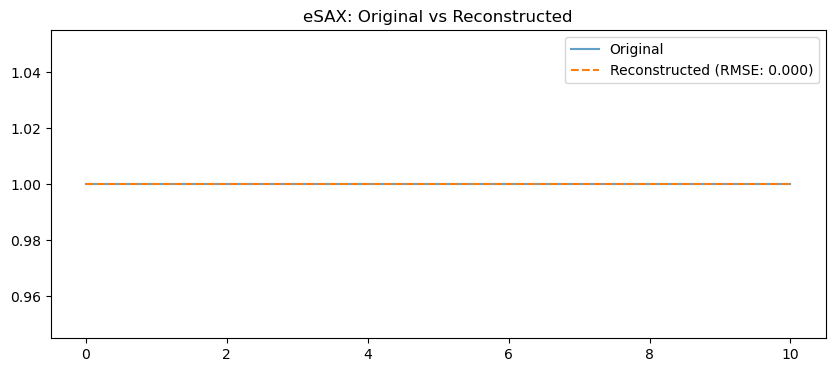

aSAX segment_sizes: [10 10 10 10 10 10 10 10 10 10], Sum: 100
aSAX segment_bounds: [  0  10  20  30  40  50  60  70  80  90 100]
aSAX reconstructed length: 100
0.0


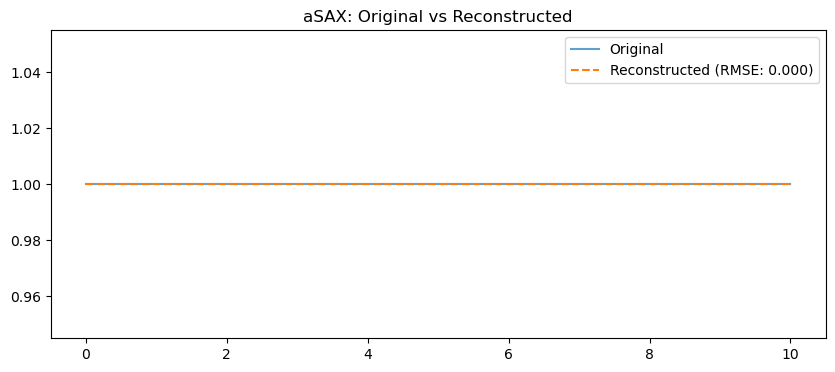


Testing short time series (length=20)
SAX reconstructed length: 20
0.41815070743011085


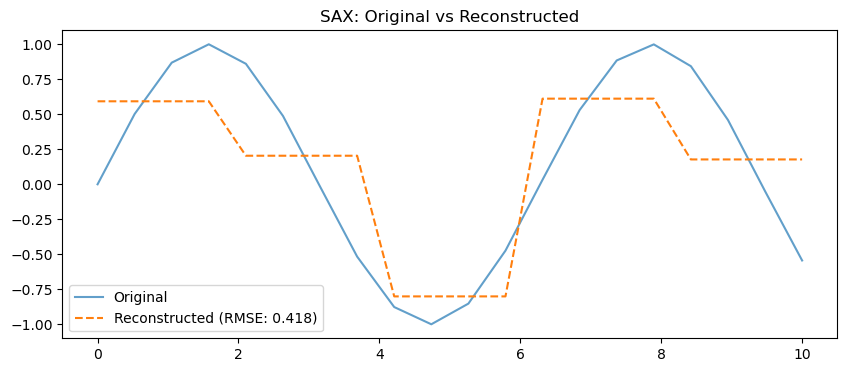

SAX-TD reconstructed length: 20
0.1607066088625464


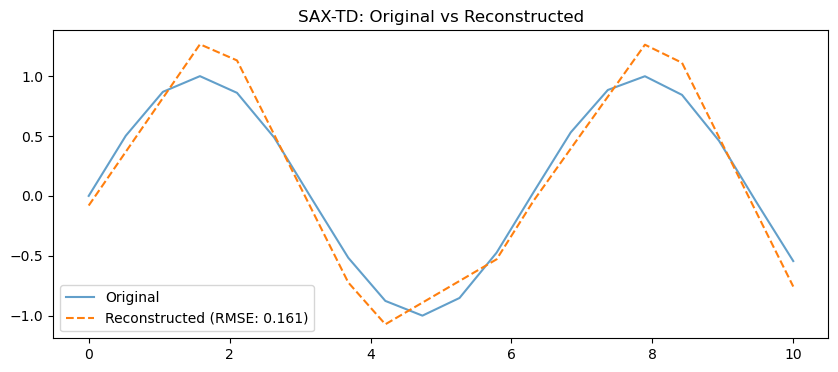

eSAX reconstructed length: 20
0.6758094853068364


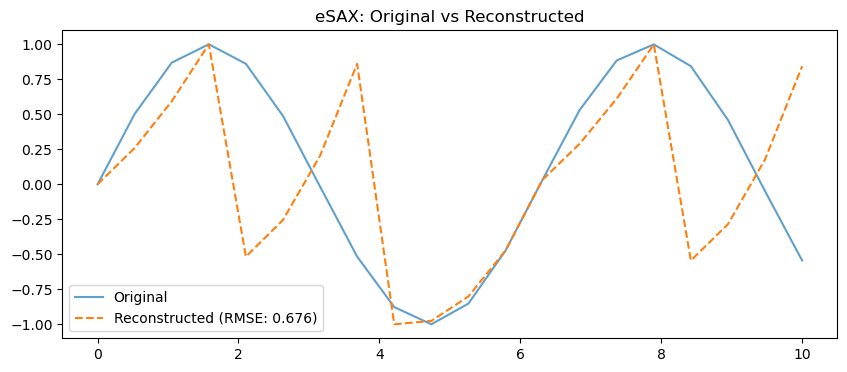

aSAX segment_sizes: [4 3 7 4 2], Sum: 20
aSAX segment_bounds: [ 0  4  7 14 18 20]
aSAX reconstructed length: 20
0.39501667546104335


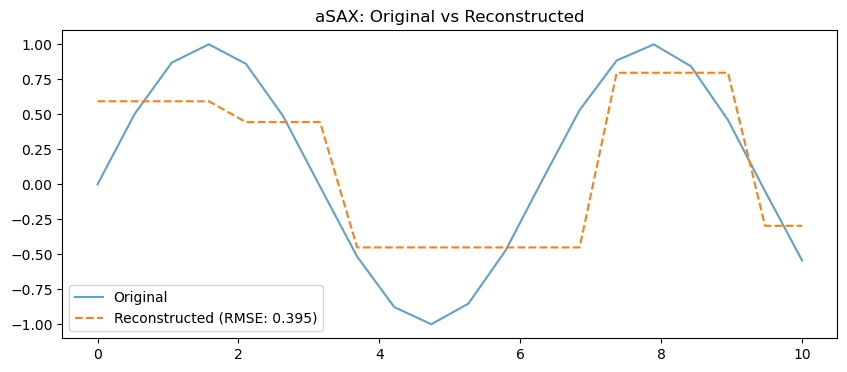

In [83]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# SAX
class SAX:
    def __init__(self, window_size, alphabet_size):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_symbols = None
    
    def fit(self, X):
        """Normalize the time series by computing mean and standard deviation.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        self : SAX
            The fitted SAX model.
        """
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        """Compute Piecewise Aggregate Approximation (PAA) and map to symbols.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence representing the time series.
        """
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        n_samples = len(X)
        if n_samples < self.window_size:
            raise ValueError(f"Input length {n_samples} < window_size {self.window_size}")
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        paa_values = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            segment = X_norm[idx:idx + size]
            mean_val = np.mean(segment)
            paa_values.append(mean_val)
            symbol = np.digitize([mean_val], self.breakpoints)[0]
            symbols.append(chr(97 + symbol))
            idx += size
        self.last_paa_values = np.array(paa_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        """Fit the model and transform the time series to symbols in one step.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence representing the time series.
        """
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        """Reconstruct the time series from symbols or stored PAA values.
        
        Parameters
        ----------
        symbols : list of str, optional
            The symbolic sequence to reconstruct from. If None, uses stored symbols.
        
        Returns
        -------
        recon : ndarray
            The reconstructed time series.
        """
        if symbols is None:
            symbols = self.last_symbols
            paa_values = self.last_paa_values
        else:
            symbols = np.array([ord(s) - 97 for s in symbols])
            breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
            paa_values = np.array([norm.expect(lambda x: x, loc=0, scale=1, 
                                              lb=breakpoints_ext[i], ub=breakpoints_ext[i+1])
                                  for i in symbols])
        recon_norm = []
        for val, size in zip(paa_values, self.segment_sizes):
            recon_norm.extend([val] * size)
        recon = np.array(recon_norm) * self.std + self.mean
        return recon

# SAX-TD
class SAXTD:
    def __init__(self, window_size, alphabet_size, slope_threshold=0.01):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.slope_threshold = slope_threshold
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_slopes = None
        self.last_symbols = None
    
    def fit(self, X):
        """Normalize the time series by computing mean and standard deviation.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        self : SAXTD
            The fitted SAX-TD model.
        """
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        """Compute PAA, slopes, and symbols with trend information.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence with trend suffixes ('u', 'd', 'f').
        """
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        n_samples = len(X)
        if n_samples < self.window_size:
            raise ValueError(f"Input length {n_samples} < window_size {self.window_size}")
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        paa_values = []
        slopes = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            start = idx
            end = idx + size
            segment = X_norm[start:end]
            mean_val = np.mean(segment)
            slope, _ = np.polyfit(np.arange(len(segment)), segment, 1)
            paa_values.append(mean_val)
            slopes.append(slope)
            mean_symbol = np.digitize([mean_val], self.breakpoints)[0]
            trend = 'u' if slope > self.slope_threshold else ('d' if slope < -self.slope_threshold else 'f')
            symbols.append(f"{chr(97 + mean_symbol)}{trend}")
            idx += size
        self.last_paa_values = np.array(paa_values)
        self.last_slopes = np.array(slopes)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        """Fit the model and transform the time series to symbols with trends.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence with trend suffixes.
        """
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        """Reconstruct the time series with linear trends from symbols.
        
        Parameters
        ----------
        symbols : list of str, optional
            The symbolic sequence with trend suffixes. If None, uses stored symbols.
        
        Returns
        -------
        recon : ndarray
            The reconstructed time series with linear trends.
        """
        if symbols is None:
            paa_values = self.last_paa_values
            slopes = self.last_slopes
        else:
            paa_values = []
            slopes = []
            for s in symbols:
                mean_symbol = ord(s[0]) - 97
                trend = s[1]
                breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                mean_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                       lb=breakpoints_ext[mean_symbol], 
                                       ub=breakpoints_ext[mean_symbol + 1])
                slope = (self.slope_threshold if trend == 'u' else 
                         (-self.slope_threshold if trend == 'd' else 0))
                paa_values.append(mean_val)
                slopes.append(slope)
            paa_values = np.array(paa_values)
            slopes = np.array(slopes)
        recon_norm = []
        for val, slope, size in zip(paa_values, slopes, self.segment_sizes):
            segment = val + slope * np.linspace(-size/2, size/2, size)
            recon_norm.extend(segment)
        recon = np.array(recon_norm) * self.std + self.mean
        return recon

# eSAX
class ESAX:
    def __init__(self, window_size, alphabet_size):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_sizes = None
        self.last_min_values = None
        self.last_mean_values = None
        self.last_max_values = None
        self.last_symbols = None
    
    def fit(self, X):
        """Normalize the time series by computing mean and standard deviation.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        self : ESAX
            The fitted eSAX model.
        """
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        """Compute min, mean, max per segment and map to symbols.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence with three symbols per segment (min, mean, max).
        """
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        n_samples = len(X)
        if n_samples < self.window_size:
            raise ValueError(f"Input length {n_samples} < window_size {self.window_size}")
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        min_values = []
        mean_values = []
        max_values = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            start = idx
            end = idx + size
            segment = X_norm[start:end]
            min_val = np.min(segment)
            mean_val = np.mean(segment)
            max_val = np.max(segment)
            min_values.append(min_val)
            mean_values.append(mean_val)
            max_values.append(max_val)
            min_symbol = np.digitize([min_val], self.breakpoints)[0]
            mean_symbol = np.digitize([mean_val], self.breakpoints)[0]
            max_symbol = np.digitize([max_val], self.breakpoints)[0]
            symbols.append(f"{chr(97 + min_symbol)}{chr(97 + mean_symbol)}{chr(97 + max_symbol)}")
            idx += size
        self.last_min_values = np.array(min_values)
        self.last_mean_values = np.array(mean_values)
        self.last_max_values = np.array(max_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        """Fit the model and transform the time series to symbols.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence with three symbols per segment.
        """
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        """Reconstruct the time series using quadratic interpolation.
        
        Parameters
        ----------
        symbols : list of str, optional
            The symbolic sequence with three symbols per segment. If None, uses stored values.
        
        Returns
        -------
        recon : ndarray
            The reconstructed time series.
        """
        if symbols is None:
            min_values = self.last_min_values
            mean_values = self.last_mean_values
            max_values = self.last_max_values
        else:
            min_values = []
            mean_values = []
            max_values = []
            for s in symbols:
                breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                min_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                      lb=breakpoints_ext[ord(s[0]) - 97], 
                                      ub=breakpoints_ext[ord(s[0]) - 96])
                mean_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                       lb=breakpoints_ext[ord(s[1]) - 97], 
                                       ub=breakpoints_ext[ord(s[1]) - 96])
                max_val = norm.expect(lambda x: x, loc=0, scale=1, 
                                      lb=breakpoints_ext[ord(s[2]) - 97], 
                                      ub=breakpoints_ext[ord(s[2]) - 96])
                min_values.append(min_val)
                mean_values.append(mean_val)
                max_values.append(max_val)
            min_values = np.array(min_values)
            mean_values = np.array(mean_values)
            max_values = np.array(max_values)
        recon_norm = []
        for min_val, mean_val, max_val, size in zip(min_values, mean_values, max_values, self.segment_sizes):
            x = [0, size/2, size-1]
            y = [min_val, mean_val, max_val]
            f = interp1d(x, y, kind='quadratic', fill_value="extrapolate")
            segment = f(np.arange(size))
            recon_norm.extend(segment)
        recon = np.array(recon_norm) * self.std + self.mean
        return recon

# mSAX
class MSAX:
    def __init__(self, window_size, alphabet_size):
        self.window_size = window_size
        self.alphabet_size = alphabet_size
        self.breakpoints = None
        self.means = None
        self.stds = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_symbols = None
    
    def fit(self, X):
        """Normalize multivariate time series per dimension.
        
        Parameters
        ----------
        X : array-like
            The input multivariate time series.
        
        Returns
        -------
        self : MSAX
            The fitted mSAX model.
        """
        X = np.asarray(X, dtype=np.float64)
        self.means = np.mean(X, axis=0)
        self.stds = np.std(X, axis=0)
        self.stds[self.stds < 1e-10] = 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        return self
    
    def transform(self, X):
        """Compute PAA per dimension and map to symbols.
        
        Parameters
        ----------
        X : array-like
            The input multivariate time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence with one symbol per dimension per segment.
        """
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.means) / self.stds
        n_samples, n_dims = X.shape
        if n_samples < self.window_size:
            raise ValueError(f"Input length {n_samples} < window_size {self.window_size}")
        base_size = n_samples // self.window_size
        remainder = n_samples % self.window_size
        self.segment_sizes = [base_size + 1 if i < remainder else base_size for i in range(self.window_size)]
        paa_values = []
        symbols = []
        idx = 0
        for size in self.segment_sizes:
            start = idx
            end = idx + size
            segment = X_norm[start:end, :]
            mean_vals = np.mean(segment, axis=0)
            paa_values.append(mean_vals)
            dim_symbols = [np.digitize([val], self.breakpoints)[0] for val in mean_vals]
            symbols.append("".join(chr(97 + s) for s in dim_symbols))
            idx += size
        self.last_paa_values = np.array(paa_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        """Fit the model and transform the multivariate time series to symbols.
        
        Parameters
        ----------
        X : array-like
            The input multivariate time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence with one symbol per dimension per segment.
        """
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        """Reconstruct the multivariate time series from symbols.
        
        Parameters
        ----------
        symbols : list of str, optional
            The symbolic sequence with one symbol per dimension. If None, uses stored values.
        
        Returns
        -------
        recon : ndarray
            The reconstructed multivariate time series.
        """
        if symbols is None:
            paa_values = self.last_paa_values
        else:
            paa_values = []
            for s in symbols:
                vals = []
                for c in s:
                    idx = ord(c) - 97
                    breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                    val = norm.expect(lambda x: x, loc=0, scale=1, 
                                      lb=breakpoints_ext[idx], ub=breakpoints_ext[idx + 1])
                    vals.append(val)
                paa_values.append(vals)
            paa_values = np.array(paa_values)
        n_dims = paa_values.shape[1]
        recon_norm = np.zeros((sum(self.segment_sizes), n_dims))
        idx = 0
        for vals, size in zip(paa_values, self.segment_sizes):
            recon_norm[idx:idx + size, :] = vals
            idx += size
        recon = recon_norm * self.stds + self.means
        return recon

# ASAX
class ASAX:
    def __init__(self, n_segments, alphabet_size, min_segment_size=5):
        self.n_segments = n_segments
        self.alphabet_size = alphabet_size
        self.min_segment_size = min_segment_size
        self.breakpoints = None
        self.mean = None
        self.std = None
        self.segment_bounds = None
        self.segment_sizes = None
        self.last_paa_values = None
        self.last_symbols = None
    
    def fit(self, X):
        """Normalize and compute adaptive segment sizes based on local variance.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        self : ASAX
            The fitted aSAX model.
        """
        X = np.asarray(X, dtype=np.float64)
        self.mean = np.mean(X)
        self.std = np.std(X) if np.std(X) > 1e-10 else 1.0
        self.breakpoints = norm.ppf(np.linspace(0, 1, self.alphabet_size + 1)[1:-1])
        n_samples = len(X)
        X_norm = (X - self.mean) / self.std
        
        # Validate n_segments
        if self.n_segments > n_samples:
            raise ValueError(f"n_segments ({self.n_segments}) cannot exceed n_samples ({n_samples})")
        if self.min_segment_size * self.n_segments > n_samples:
            print(f"Warning: min_segment_size ({self.min_segment_size}) too large for n_samples ({n_samples}). Adjusting.")
        
        # Compute adaptive segment sizes based on local std
        window = max(n_samples // self.n_segments, 1)
        stds = [np.std(X_norm[i:i + window]) if i + window <= n_samples else np.std(X_norm[i:]) 
                for i in range(0, n_samples, window)]
        stds = np.array(stds)
        if len(stds) < self.n_segments:
            stds = np.pad(stds, (0, self.n_segments - len(stds)), mode='edge')
        elif len(stds) > self.n_segments:
            stds = stds[:self.n_segments]
        inv_stds = 1 / (stds + 1e-10)
        total_weight = inv_stds.sum()
        
        # Compute initial segment sizes
        segment_sizes = np.round(inv_stds / total_weight * n_samples).astype(int)
        # Ensure at least 1 point per segment
        segment_sizes = np.clip(segment_sizes, 1, None)
        
        # Adjust to ensure sum equals n_samples
        current_sum = segment_sizes.sum()
        if current_sum != n_samples:
            diff = n_samples - current_sum
            if diff > 0:
                # Add points to segments with highest weights
                sorted_indices = np.argsort(inv_stds)[::-1]
                for i in range(diff):
                    segment_sizes[sorted_indices[i % self.n_segments]] += 1
            elif diff < 0:
                # Remove points from segments with lowest weights, respecting min size
                sorted_indices = np.argsort(inv_stds)
                i = 0
                while diff < 0 and i < self.n_segments:
                    idx = sorted_indices[i % self.n_segments]
                    if segment_sizes[idx] > 1:
                        segment_sizes[idx] -= 1
                        diff += 1
                    i += 1
                # If still not resolved, use equal sizes
                if diff < 0:
                    print("Warning: Falling back to equal segment sizes due to constraints")
                    base_size = n_samples // self.n_segments
                    remainder = n_samples % self.n_segments
                    segment_sizes = np.array([base_size + 1 if i < remainder else base_size 
                                             for i in range(self.n_segments)])
        
        self.segment_sizes = segment_sizes
        self.segment_bounds = np.cumsum([0] + segment_sizes.tolist())
        
        # Validate
        print(f"aSAX segment_sizes: {self.segment_sizes}, Sum: {self.segment_sizes.sum()}")
        print(f"aSAX segment_bounds: {self.segment_bounds}")
        if self.segment_bounds[-1] != n_samples or len(self.segment_sizes) != self.n_segments:
            raise ValueError(f"Invalid segment bounds: {self.segment_bounds[-1]} vs {n_samples}, "
                             f"or wrong number of segments: {len(self.segment_sizes)} vs {self.n_segments}")
        
        return self
    
    def transform(self, X):
        """Compute PAA for adaptive segments and map to symbols.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence for adaptive segments.
        """
        X = np.asarray(X, dtype=np.float64)
        X_norm = (X - self.mean) / self.std
        paa_values = []
        symbols = []
        for i in range(self.n_segments):
            start = self.segment_bounds[i]
            end = self.segment_bounds[i + 1]
            if start >= end or end > len(X_norm):
                raise ValueError(f"Invalid segment [{start}:{end}] for length {len(X_norm)}")
            segment = X_norm[start:end]
            mean_val = np.mean(segment)
            if np.isnan(mean_val):
                mean_val = 0
            paa_values.append(mean_val)
            symbol = np.digitize([mean_val], self.breakpoints)[0]
            symbols.append(chr(97 + symbol))
        self.last_paa_values = np.array(paa_values)
        self.last_symbols = np.array(symbols)
        return self.last_symbols
    
    def fit_transform(self, X):
        """Fit the model and transform the time series to symbols.
        
        Parameters
        ----------
        X : array-like
            The input time series.
        
        Returns
        -------
        symbols : list of str
            The symbolic sequence for adaptive segments.
        """
        return self.fit(X).transform(X)
    
    def inverse_transform(self, symbols=None):
        """Reconstruct the time series from adaptive segments.
        
        Parameters
        ----------
        symbols : list of str, optional
            The symbolic sequence to reconstruct from. If None, uses stored symbols.
        
        Returns
        -------
        recon : ndarray
            The reconstructed time series.
        """
        if symbols is None:
            paa_values = self.last_paa_values
        else:
            paa_values = []
            for s in symbols:
                idx = ord(s) - 97
                breakpoints_ext = np.concatenate([[-np.inf], self.breakpoints, [np.inf]])
                val = norm.expect(lambda x: x, loc=0, scale=1, 
                                  lb=breakpoints_ext[idx], ub=breakpoints_ext[idx + 1])
                paa_values.append(val)
            paa_values = np.array(paa_values)
        recon_norm = []
        for i, val in enumerate(paa_values):
            segment_size = self.segment_bounds[i + 1] - self.segment_bounds[i]
            recon_norm.extend([val] * segment_size)
        recon = np.array(recon_norm) * self.std + self.mean
        return recon

# Test function to run and visualize
def test_sax_variant(model, ts, t, name, is_multivariate=False):
    """Test a SAX variant by transforming and reconstructing a time series.
    
    Parameters
    ----------
    model : object
        The SAX variant model (e.g., SAX, SAXTD, ESAX, MSAX, ASAX).
    ts : array-like
        The input time series (univariate or multivariate).
    t : array-like
        The time points for plotting.
    name : str
        The name of the SAX variant for display.
    is_multivariate : bool, optional
        Whether the time series is multivariate. Default is False.
    
    Returns
    -------
    rmse : float
        The root mean squared error between original and reconstructed series.
    """
    symbols = model.fit_transform(ts)
    recon = model.inverse_transform()
    print(f"{name} reconstructed length: {len(recon)}")
    rmse = np.sqrt(np.mean((ts - recon) ** 2))
    print(rmse)
    if is_multivariate:
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(t, ts[:, 0], label="Original Dim 1", alpha=0.7)
        plt.plot(t, recon[:, 0], label="Reconstructed Dim 1", linestyle="--")
        plt.legend()
        plt.title(f"{name}: Dim 1 (RMSE: {rmse:.3f})")
        plt.subplot(1, 2, 2)
        plt.plot(t, ts[:, 1], label="Original Dim 2", alpha=0.7)
        plt.plot(t, recon[:, 1], label="Reconstructed Dim 2", linestyle="--")
        plt.legend()
        plt.title(f"{name}: Dim 2")
        plt.tight_layout()
    else:
        
        plt.figure(figsize=(10, 4))
        plt.plot(t, ts, label="Original", alpha=0.7)
        plt.plot(t, recon, label=f"Reconstructed (RMSE: {rmse:.3f})", linestyle="--")
        plt.title(f"{name}: Original vs Reconstructed")
        plt.legend()
    plt.show()
    return rmse

import pickle
try:
    with open('test_rmse.pkl', 'rb') as f:
        check_list = pickle.load(f)
except FileNotFoundError:
    check_list = None


# Generate test time series
np.random.seed(42)
t = np.linspace(0, 10, 100)
ts = np.sin(t) + np.random.normal(0, 0.1, 100)  # Univariate, main test
ts_multi = np.vstack([np.sin(t), np.cos(t)]).T + np.random.normal(0, 0.1, (100, 2))  # Multivariate
ts_constant = np.ones(100)  # Edge case: constant series
t_short = np.linspace(0, 10, 20)
ts_short = np.sin(t_short)  # Edge case: short series


RMSE = list()
# Main test: standard time series
print("Testing standard time series (length=100)")
sax = SAX(window_size=10, alphabet_size=8)
rmse = test_sax_variant(sax, ts, t, "SAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[0] == rmse

saxtd = SAXTD(window_size=10, alphabet_size=8)
rmse = test_sax_variant(saxtd, ts, t, "SAX-TD")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[1] == rmse
    
esax = ESAX(window_size=10, alphabet_size=8)
rmse = test_sax_variant(esax, ts, t, "eSAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[2] == rmse
    
msax = MSAX(window_size=10, alphabet_size=8)
rmse = test_sax_variant(msax, ts_multi, t, "mSAX", is_multivariate=True)
RMSE.append(rmse)
if check_list is not None:
    assert check_list[3] == rmse
    
asax = ASAX(n_segments=10, alphabet_size=8)
rmse = test_sax_variant(asax, ts, t, "aSAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[4] == rmse
    
# Edge case: constant time series
print("\nTesting constant time series (length=100)")
sax = SAX(window_size=10, alphabet_size=8)
rmse = test_sax_variant(sax, ts_constant, t, "SAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[5] == rmse
    
saxtd = SAXTD(window_size=10, alphabet_size=8)
rmse = test_sax_variant(saxtd, ts_constant, t, "SAX-TD")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[6] == rmse
    
esax = ESAX(window_size=10, alphabet_size=8)
rmse = test_sax_variant(esax, ts_constant, t, "eSAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[7] == rmse
    
asax = ASAX(n_segments=10, alphabet_size=8)
rmse = test_sax_variant(asax, ts_constant, t, "aSAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[8] == rmse
    
# Edge case: short time series
print("\nTesting short time series (length=20)")
sax = SAX(window_size=5, alphabet_size=8)
rmse = test_sax_variant(sax, ts_short, t_short, "SAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[9] == rmse
    
saxtd = SAXTD(window_size=5, alphabet_size=8)
rmse = test_sax_variant(saxtd, ts_short, t_short, "SAX-TD")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[10] == rmse
    
esax = ESAX(window_size=5, alphabet_size=8)
rmse = test_sax_variant(esax, ts_short, t_short, "eSAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[11] == rmse
    
asax = ASAX(n_segments=5, alphabet_size=8)
rmse = test_sax_variant(asax, ts_short, t_short, "aSAX")
RMSE.append(rmse)
if check_list is not None:
    assert check_list[12] == rmse



if check_list is None:
    with open('test_rmse.pkl', 'wb') as f:
        pickle.dump(RMSE, f)

In [76]:
loaded_list

[0.2353862649856282,
 0.08755080560648505,
 0.35562841562115677,
 0.21873322830378136,
 0.19375838808452822,
 0.0,
 0.0,
 0.0,
 0.0,
 0.41815070743011085,
 0.1607066088625464,
 0.6758094853068364,
 0.39501667546104335]

In [77]:
with open('rmse.pkl', 'rb') as f:
    loaded_list = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'rmse.pkl'